In [1]:
!git clone https://github.com/RIPS-2024-Aerospace/Aerospace-Project.git

Cloning into 'Aerospace-Project'...
remote: Enumerating objects: 389, done.
remote: Counting objects: 100% (120/120), done.
remote: Compressing objects: 100% (69/69), done.
remote: Total 389 (delta 91), reused 59 (delta 51), pack-reused 269
Receiving objects: 100% (389/389), 23.72 MiB | 12.77 MiB/s, done.
Resolving deltas: 100% (181/181), done.


In [6]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
from scipy.optimize import minimize

%run "./Aerospace-Project/Standard Filters/DiffKf.ipynb"
%run "./Aerospace-Project/Standard Filters/KF.ipynb"

In [3]:
# Bhattacharyya distance function
def bhattacharyya_distance(mu1, mu2, Sigma1, Sigma2):
    # Sigma1 = covariance of diff KF
    # Sigma2 = covariance of centralized KF
    # mu1 = mean of diff KF
    # mu2 = mean of centralized KF

    Sigma = (Sigma1 + Sigma2) / 2
    inv_Sigma = np.linalg.inv(Sigma)
    term1 = 1/8 * np.dot(np.dot((mu1 - mu2).T, inv_Sigma), (mu1 - mu2))
    term2 = 1/2 * np.log(np.linalg.det(Sigma) / np.sqrt(np.linalg.det(Sigma1) * np.linalg.det(Sigma2)))
    return term1 + term2

# Function to run filters and return covariances
def run_filters(W):
    print(W)
    dt = 10

    # define C
    C_adj = np.array([[1, 1, 0, 0, 1],
                      [1, 1, 1, 0, 0],
                      [0, 1, 1, 1, 0],
                      [0, 0, 1, 1, 1],
                      [1, 0, 0, 1, 1]])
    C = C_adj * np.reshape(W, (5, 5))
    C_unweighted = np.array([[1 if x != 0 else 0 for x in row] for row in C])
    num_stns = len(C[0])

    A = np.array([[1, dt, 0, 0], [0, 1, 0, 0],[0,0,1,dt], [0, 0, 0, 1]])
    H = np.array([[1, 0, 0, 0],[0,0,1,0]])

    dkf_state_size = len(A)
    dkf_measure_size = len(H)

    q = 0.001
    Q = q*np.array([[(dt**3)/3, (dt**2)/2, 0, 0], [(dt**2)/2, dt, 0, 0],[0,0,(dt**3)/3,(dt**2)/2], [0, 0, (dt**2)/2, dt]])
    R = np.array([[4,0],[0,4]])

    A_kf = np.kron(np.eye(num_stns), A)
    H_kf = np.kron(np.eye(num_stns), H)
    Q_kf = np.kron(np.eye(num_stns), Q)
    R_kf = np.kron(np.eye(num_stns), R)

    kf_state_size = A_kf.shape[0]
    kf_measure_size = R_kf.shape[0]

    F = [A for _ in range(num_stns)]
    G = [np.eye(A.shape[0]) for _ in range(num_stns)]
    H_dkf = [H for _ in range(num_stns)]

    Q_dkf = [Q for _ in range(num_stns)]
    R_dkf = [R for _ in range(num_stns)]

    procc_noise_kf = lambda : np.linalg.cholesky(Q_kf) @ np.random.normal(np.array([[0 for _ in range(kf_state_size)]]).T)
    measure_noise_kf = lambda : np.linalg.cholesky(R_kf) @ np.random.normal(np.array([[0 for _ in range(kf_measure_size)]]).T)

    measure_kf_to_dkf  = lambda z: [np.array([z[H.shape[0]*i + j] for j in range(H.shape[0])]) for i in range(num_stns)]
    state_kf_to_dkf = lambda z: [np.array([z[A.shape[0]*i + j] for j in range(A.shape[0])]) for i in range(num_stns)]

    # True Initial
    x0_kf = np.array([[np.random.normal(0, np.sqrt(Q_kf[i, i])) for i in range(kf_state_size)]]).T

    # Initial Estimate
    x_kf = np.array([[np.random.normal(0, 5) for i in range(kf_state_size)]]).T
    x_dkf = state_kf_to_dkf(x_kf)

    P_kf = 10 * np.copy(Q_kf)
    P_dkf = [10 * np.copy(Q) for _ in range(num_stns)]

    kf = KalmanFilter(A=A_kf, H=H_kf, Q=Q_kf, R=R_kf, P=P_kf, x0=x0_kf)
    dkf = DiffKF(C, F, G, H_dkf, R_dkf, Q_dkf, x_dkf, P_dkf)

    iters = 60

    truth = np.zeros((iters + 1, kf_state_size, 1))
    truth[0] = x0_kf

    measurements = np.zeros((iters + 1, kf_measure_size, 1))
    measurements[0] = (H_kf @ x0_kf) + measure_noise_kf()

    predictions_kf = np.zeros((iters, kf_state_size, 1))
    predictions_dkf = np.zeros((iters, num_stns, A.shape[0], 1))

    errors_kf = np.zeros((iters, kf_state_size, 1))
    errors_dkf = np.zeros((iters, num_stns, A.shape[0], 1))

    P_hist_kf = np.zeros((iters, kf_state_size, kf_state_size))
    P_hist_dkf = np.zeros((iters, num_stns, A.shape[0], A.shape[0]))
    full_system_P_hist = np.zeros((iters, kf_state_size, kf_state_size))
    prev_cov = np.block([[np.zeros(P_dkf[0].shape) if i != j else dkf.nodes[i].P for j in range(num_stns)] for i in range(num_stns)])

    for i in range(iters):
        kf.update(measurements[i])
        dkf.update(measure_kf_to_dkf(measurements[i]))

        predictions_dkf[i] = [dkf.nodes[j].x for j in range(num_stns)]
        errors_dkf[i] = [dkf.nodes[j].x - state_kf_to_dkf(truth[i])[j] for j in range(num_stns)]
        station_covs = [dkf.nodes[j].P for j in range(num_stns)]
        P_hist_dkf[i] = station_covs

        prev_cov = get_diff_cov(prev_cov, station_covs, C)
        full_system_P_hist[i] = prev_cov

        predictions_kf[i] = kf.x
        errors_kf[i] = kf.x - truth[i]
        P_hist_kf[i] = kf.P

        kf.predict()
        dkf.predict()

        truth[i + 1] = A_kf @ x0_kf + procc_noise_kf()
        measurements[i + 1] = H_kf @ truth[i + 1] + measure_noise_kf()

    return (P_hist_kf[40], full_system_P_hist[40])

# Function to get diffusion covariance
def get_diff_cov(prev_cov, Station_cov, C):
    num_stns = len(C)
    dkf_state_size = prev_cov.shape[0] // num_stns
    dt = 10
    A = np.array([[1, dt, 0, 0], [0, 1, 0, 0], [0, 0, 1, dt], [0, 0, 0, 1]])
    G = np.eye(dkf_state_size)
    Q = 0.001 * np.array([[(dt**3)/3, (dt**2)/2, 0, 0], [(dt**2)/2, dt, 0, 0], [0, 0, (dt**3)/3, (dt**2)/2], [0, 0, (dt**2)/2, dt]])
    H = np.array([[1, 0, 0, 0], [0, 0, 1, 0]])
    R = np.array([[4, 0], [0, 4]])

    S = lambda i: np.sum([H.T @ np.linalg.inv(R) @ H for _ in range(num_stns)], axis=0)

    S_full = np.block([[np.zeros(A.shape) if i != j else S(j) for j in range(num_stns)] for i in range(num_stns)])
    H_full = np.kron(np.eye(num_stns), H)
    P_full = np.block([[np.zeros(Station_cov[0].shape) if i != j else Station_cov[j] for j in range(num_stns)] for i in range(num_stns)])
    R_full = np.kron(np.eye(num_stns), R)

    C_full = np.kron(C, np.eye(dkf_state_size))
    A_full = np.kron(np.eye(num_stns), np.eye(dkf_state_size))

    # Compute the covariance (equation 32)
    F_i = C_full.T @ (np.eye(S_full.shape[1]) - (P_full @ S_full)) @ np.kron(np.eye(num_stns), A)
    G_i = C_full.T @ (np.eye(S_full.shape[1]) - (P_full @ S_full)) @ np.kron(np.eye(num_stns), G)
    D_i = C_full.T @ P_full @ A_full.T @ H_full.T @ np.linalg.inv(R_full)

    term1 = F_i @ prev_cov @ F_i.T
    term2 = G_i @ np.kron(np.ones((num_stns, num_stns)), Q) @ G_i.T
    term3 = D_i @ R_full @ D_i.T

    return term1 + term2 + term3

In [4]:
# Define the cost function for optimization
def cost_func(diffusion_weights):
    dt = 10
    num_stns = 5
    A = np.array([[1, dt, 0, 0], [0, 1, 0, 0], [0, 0, 1, dt], [0, 0, 0, 1]])
    H = np.array([[1, 0, 0, 0], [0, 0, 1, 0]])
    q = 0.001
    Q = q * np.array([[(dt**3) / 3, (dt**2) / 2, 0, 0],
                      [(dt**2) / 2, dt, 0, 0],
                      [0, 0, (dt**3) / 3, (dt**2) / 2],
                      [0, 0, (dt**2) / 2, dt]])
    R = np.array([[4, 0], [0, 4]])

    kf_state_size = A.shape[0] * num_stns
    kf_measure_size = H.shape[0] * num_stns

    mu1 = np.zeros(kf_state_size) # vector initialized to 0
    mu2 = np.zeros(kf_state_size) # vector initialized to 0
    sigmas = run_filters(diffusion_weights)
    Sigma2 = sigmas[0] # state covariance of centralized KF
    Sigma1 = sigmas[1] # state covariance of diffusion KF
    return bhattacharyya_distance(mu1, mu2, Sigma1, Sigma2)

[0.34    0.33    0.      0.      0.33    0.33    0.34001 0.33    0.
 0.      0.      0.33    0.34    0.33    0.      0.      0.      0.33
 0.34    0.33    0.33    0.      0.      0.33    0.34   ]
[0.34    0.33    0.      0.      0.33    0.33    0.33999 0.33    0.
 0.      0.      0.33    0.34    0.33    0.      0.      0.      0.33
 0.34    0.33    0.33    0.      0.      0.33    0.34   ]
[0.34       0.33       0.         0.         0.33       0.3428738
 0.31425239 0.3428738  0.         0.         0.         0.33
 0.34       0.33       0.         0.         0.         0.33
 0.34       0.33       0.33       0.         0.         0.33
 0.34      ]
[0.34       0.33001    0.         0.         0.33       0.3428738
 0.31425239 0.3428738  0.         0.         0.         0.33
 0.34       0.33       0.         0.         0.         0.33
 0.34       0.33       0.33       0.         0.         0.33
 0.34      ]
[0.34       0.32999    0.         0.         0.33       0.3428738
 0.31425239 0.3428

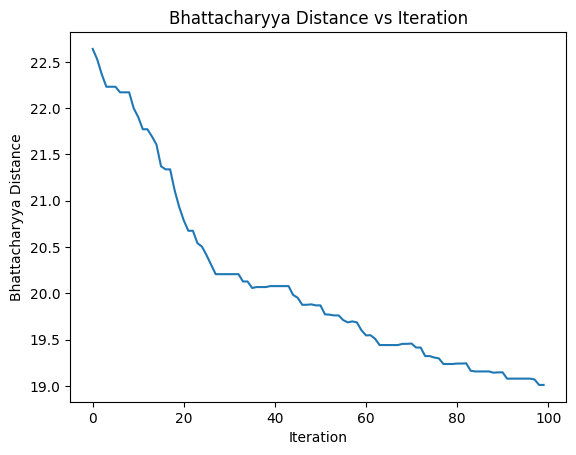

Best weights matrix:
[[0.29455728 0.39975701 0.         0.         0.30568571]
 [0.44414425 0.21297025 0.3428855  0.         0.        ]
 [0.         0.40444243 0.10890747 0.4866501  0.        ]
 [0.         0.         0.32872323 0.2887241  0.38255267]
 [0.44545359 0.         0.         0.34360559 0.21094082]]
Row sums: [1. 1. 1. 1. 1.]
Final Bhattacharyya distance: 19.010769957700372


In [9]:
# Stochastic Gradient Descent function for optimization
def stochastic_gradient_descent(initial_weights, learning_rate, iterations):
    weights = initial_weights.copy() # copy initial weights for a starter
    history = []  # stores history of b distance

    for iteration in range(iterations):
        gradient = np.zeros_like(weights)

        # Compute the gradient for a random subset of the weights with weight changes
        idx = np.random.randint(0, len(weights))  # Randomly select an index
        weights[idx] += 1e-5
        cost_plus = cost_func(weights)
        weights[idx] -= 2e-5
        cost_minus = cost_func(weights)
        gradient[idx] = (cost_plus - cost_minus) / 2e-5
        weights[idx] += 1e-5  # Restore the original weight

        # Update the weights using the gradient
        weights -= learning_rate * gradient

        # Apply row stochasticity constraint
        for i in range(0, len(weights), 5):
            row = weights[i:i + 5]
            row_sum = np.sum(row)
            if row_sum != 0:
                weights[i:i + 5] /= row_sum

        history.append(cost_func(weights))

    return weights, history

# Run the optimization
def run_optimize():
    # Define initial weights matrix C

    C = np.array([[0.34, 0.33, 0, 0, 0.33],
                  [0.33, 0.34, 0.33, 0, 0],
                  [0, 0.33, 0.34, 0.33, 0],
                  [0, 0, 0.33, 0.34, 0.33],
                  [0.33, 0, 0, 0.33, 0.34]])

    # Define adjacency matrix for non-zero connections
    C_adj = np.array([[1, 1, 0, 0, 1],
                      [1, 1, 1, 0, 0],
                      [0, 1, 1, 1, 0],
                      [0, 0, 1, 1, 1],
                      [1, 0, 0, 1, 1]])

    # Flatten C matrix to use as initial weights
    initial_weights = C.flatten()

    # Run stochastic gradient descent
    learning_rate = 0.01
    iterations = 100
    best_weights, history = stochastic_gradient_descent(initial_weights, learning_rate, iterations)

    # Plot the cost function history
    plt.plot(range(iterations), history)
    plt.xlabel('Iteration')
    plt.ylabel('Bhattacharyya Distance')
    plt.title('Bhattacharyya Distance vs Iteration')
    plt.show()

    # Check if each row in the final best weights matrix sums to 1
    best_weights_matrix = np.reshape(best_weights, (5, 5))  # Reshape weights to matrix form
    row_sums = np.sum(best_weights_matrix, axis=1)  # Compute sum of each row
    print(f'Best weights matrix:\n{best_weights_matrix}')
    print(f'Row sums: {row_sums}')
    print(f'Final Bhattacharyya distance: {history[-1]}')

run_optimize()

[2.9455728e-01 3.9975701e-01 0.0000000e+00 0.0000000e+00 3.0568571e-01
 4.4414425e-01 2.1297025e-01 3.4288550e-01 0.0000000e+00 0.0000000e+00
 0.0000000e+00 4.0444243e-01 1.0890747e-01 4.8665010e-01 0.0000000e+00
 0.0000000e+00 0.0000000e+00 3.2872323e-01 2.8872410e-01 3.8255267e-01
 4.4545359e-01 0.0000000e+00 1.0000000e-05 3.4360559e-01 2.1094082e-01]
[ 2.9455728e-01  3.9975701e-01  0.0000000e+00  0.0000000e+00
  3.0568571e-01  4.4414425e-01  2.1297025e-01  3.4288550e-01
  0.0000000e+00  0.0000000e+00  0.0000000e+00  4.0444243e-01
  1.0890747e-01  4.8665010e-01  0.0000000e+00  0.0000000e+00
  0.0000000e+00  3.2872323e-01  2.8872410e-01  3.8255267e-01
  4.4545359e-01  0.0000000e+00 -1.0000000e-05  3.4360559e-01
  2.1094082e-01]
[0.29455728 0.39975701 0.         0.         0.30568571 0.44414425
 0.21297025 0.3428855  0.         0.         0.         0.40444243
 0.10890747 0.4866501  0.         0.         0.         0.32872323
 0.2887241  0.38255267 0.44545359 0.         0.         0.34

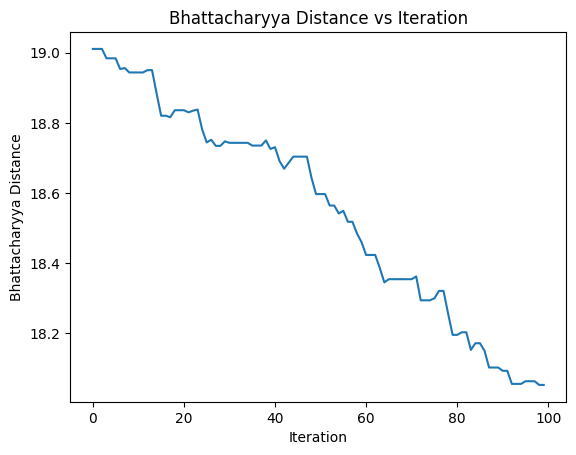

Best weights matrix:
[[0.24501045 0.43030455 0.         0.         0.324685  ]
 [0.38312047 0.21090373 0.40597579 0.         0.        ]
 [0.         0.4185842  0.0345006  0.54691519 0.        ]
 [0.         0.         0.32433789 0.28083671 0.39482539]
 [0.57250024 0.         0.         0.28358144 0.14391832]]
Row sums: [1. 1. 1. 1. 1.]
Final Bhattacharyya distance: 18.05322140526876


In [10]:
# Stochastic Gradient Descent function for optimization
def stochastic_gradient_descent(initial_weights, learning_rate, iterations):
    weights = initial_weights.copy() # copy initial weights for a starter
    history = []  # stores history of b distance

    for iteration in range(iterations):
        gradient = np.zeros_like(weights)

        # Compute the gradient for a random subset of the weights with weight changes
        idx = np.random.randint(0, len(weights))  # Randomly select an index
        weights[idx] += 1e-5
        cost_plus = cost_func(weights)
        weights[idx] -= 2e-5
        cost_minus = cost_func(weights)
        gradient[idx] = (cost_plus - cost_minus) / 2e-5
        weights[idx] += 1e-5  # Restore the original weight

        # Update the weights using the gradient
        weights -= learning_rate * gradient

        # Apply row stochasticity constraint
        for i in range(0, len(weights), 5):
            row = weights[i:i + 5]
            row_sum = np.sum(row)
            if row_sum != 0:
                weights[i:i + 5] /= row_sum

        history.append(cost_func(weights))

    return weights, history

# Run the optimization
def run_optimize():
    # Define initial weights matrix C
    C = np.array([[0.29455728, 0.39975701, 0, 0, 0.30568571],
                  [0.44414425, 0.21297025, 0.3428855, 0, 0],
                  [0, 0.40444243, 0.10890747, 0.4866501, 0],
                  [0, 0, 0.32872323, 0.2887241, 0.38255267],
                  [0.44545359, 0, 0, 0.34360559, 0.21094082]])

    # Define adjacency matrix for non-zero connections
    C_adj = np.array([[1, 1, 0, 0, 1],
                      [1, 1, 1, 0, 0],
                      [0, 1, 1, 1, 0],
                      [0, 0, 1, 1, 1],
                      [1, 0, 0, 1, 1]])

    # Flatten C matrix to use as initial weights
    initial_weights = C.flatten()

    # Run stochastic gradient descent
    learning_rate = 0.01
    iterations = 100
    best_weights, history = stochastic_gradient_descent(initial_weights, learning_rate, iterations)

    # Plot the cost function history
    plt.plot(range(iterations), history)
    plt.xlabel('Iteration')
    plt.ylabel('Bhattacharyya Distance')
    plt.title('Bhattacharyya Distance vs Iteration')
    plt.show()

    # Check if each row in the final best weights matrix sums to 1
    best_weights_matrix = np.reshape(best_weights, (5, 5))  # Reshape weights to matrix form
    row_sums = np.sum(best_weights_matrix, axis=1)  # Compute sum of each row
    print(f'Best weights matrix:\n{best_weights_matrix}')
    print(f'Row sums: {row_sums}')
    print(f'Final Bhattacharyya distance: {history[-1]}')

run_optimize()

[0.24501045 0.43030455 0.         0.         0.324685   0.38312047
 0.21090373 0.40597579 0.         0.         0.         0.4185842
 0.0345006  0.54692519 0.         0.         0.         0.32433789
 0.28083671 0.39482539 0.57250024 0.         0.         0.28358144
 0.14391832]
[0.24501045 0.43030455 0.         0.         0.324685   0.38312047
 0.21090373 0.40597579 0.         0.         0.         0.4185842
 0.0345006  0.54690519 0.         0.         0.         0.32433789
 0.28083671 0.39482539 0.57250024 0.         0.         0.28358144
 0.14391832]
[0.24501045 0.43030455 0.         0.         0.324685   0.38312047
 0.21090373 0.40597579 0.         0.         0.         0.40488838
 0.03337176 0.56173986 0.         0.         0.         0.32433789
 0.28083671 0.39482539 0.57250024 0.         0.         0.28358144
 0.14391832]
[0.24501045 0.43030455 0.         0.         0.324685   0.38312047
 0.21091373 0.40597579 0.         0.         0.         0.40488838
 0.03337176 0.56173986 0.

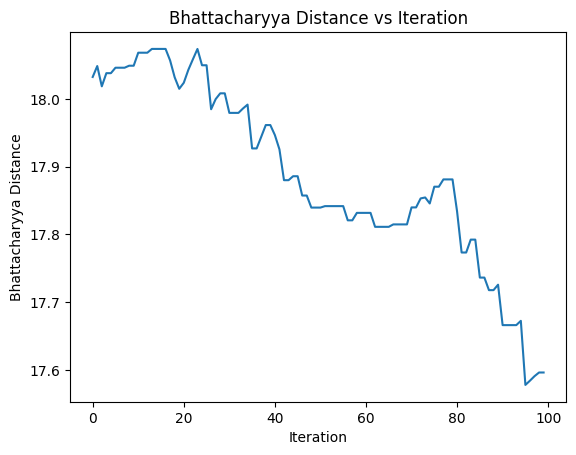

Best weights matrix:
[[0.21617142 0.415557   0.         0.         0.36827158]
 [0.37992846 0.21398962 0.40608192 0.         0.        ]
 [0.         0.41395969 0.01028063 0.57575968 0.        ]
 [0.         0.         0.28065008 0.30907167 0.41027826]
 [0.62177517 0.         0.         0.25923958 0.11898524]]
Row sums: [1. 1. 1. 1. 1.]
Final Bhattacharyya distance: 17.59617686058478


In [11]:
# Run the optimization
def run_optimize():
    # Define initial weights matrix C
    C = np.array([[0.24501045, 0.43030455, 0, 0, 0.324685],
                  [0.38312047, 0.21090373, 0.40597579, 0, 0],
                  [0, 0.4185842, 0.0345006, 0.54691519, 0],
                  [0, 0, 0.32433789, 0.28083671, 0.39482539],
                  [0.57250024, 0, 0, 0.28358144, 0.14391832]])

    # Define adjacency matrix for non-zero connections
    C_adj = np.array([[1, 1, 0, 0, 1],
                      [1, 1, 1, 0, 0],
                      [0, 1, 1, 1, 0],
                      [0, 0, 1, 1, 1],
                      [1, 0, 0, 1, 1]])

    # Flatten C matrix to use as initial weights
    initial_weights = C.flatten()

    # Run stochastic gradient descent
    learning_rate = 0.01
    iterations = 100
    best_weights, history = stochastic_gradient_descent(initial_weights, learning_rate, iterations)

    # Plot the cost function history
    plt.plot(range(iterations), history)
    plt.xlabel('Iteration')
    plt.ylabel('Bhattacharyya Distance')
    plt.title('Bhattacharyya Distance vs Iteration')
    plt.show()

    # Check if each row in the final best weights matrix sums to 1
    best_weights_matrix = np.reshape(best_weights, (5, 5))  # Reshape weights to matrix form
    row_sums = np.sum(best_weights_matrix, axis=1)  # Compute sum of each row
    print(f'Best weights matrix:\n{best_weights_matrix}')
    print(f'Row sums: {row_sums}')
    print(f'Final Bhattacharyya distance: {history[-1]}')

run_optimize()